In [ ]:
#pip install pandas numpy matplotlib seaborn scikit-learn openpyxl
import pandas as pd

#Loading order number and Dates 
df_orders = pd.read_excel("data_task.xlsx", sheet_name="order_numbers")

df_orders['date'] = pd.to_datetime(df_orders['date'])
df_orders = df_orders.sort_values('date').reset_index(drop=True)
df_orders['order_diff'] = df_orders['order_number'].diff()


bad_points = df_orders[df_orders['order_diff'] <= 0]
print("Bad points where order numbers didn't inc:")
print(bad_points)
df_clean = df_orders[df_orders['order_diff'] > 0].copy()


df_clean = df_clean[df_clean['order_diff'] < 1_000_000]


df_clean.reset_index(drop=True, inplace=True)

# Showing clean data
print("Cleaned data preview:")
print(df_clean.head(10))



Bad points where order numbers didn't inc:
          date  order_number  order_diff
11  2018-03-22      35482998  -1310484.0
15  2018-04-03      35559751  -3033672.0
23  2018-05-08      36368212    -16150.0
26  2018-05-13      36408976   -192112.0
28  2018-05-19      36569135   -174356.0
..         ...           ...         ...
733 2022-04-17      79208916   -920388.0
735 2022-04-21      80010988   -458500.0
737 2022-04-22      78270297  -2285474.0
739 2022-04-24      11337408 -69249743.0
756 2022-06-28      82632637   -355201.0

[218 rows x 3 columns]
Cleaned data preview:
        date  order_number  order_diff
0 2018-01-22      34008921    167015.0
1 2018-01-25      34397468    388547.0
2 2018-02-06      34434432     36964.0
3 2018-02-08      34579365    144933.0
4 2018-03-05      35059326    479961.0
5 2018-03-06      35147248     87922.0
6 2018-03-10      35191739     44491.0
7 2018-03-19      35342996    151257.0
8 2018-03-20      35433679     90683.0
9 2018-03-27      35545393   

In [44]:
# Loading transaction data
df_tx = pd.read_excel("data_task.xlsx", sheet_name="transaction_data")

df_tx['date'] = pd.to_datetime(df_tx['date'])

print("Transaction data loaded:")
print(df_tx.head())


Transaction data loaded:
        date  total_spend_index  gross_orders_index  weekly_active_users_index
0 2018-01-01           0.052537            0.158983                   1.563652
1 2018-01-02           0.839176            1.430843                   1.628314
2 2018-01-03           0.182855            0.476948                   1.633740
3 2018-01-04           2.364675            1.907790                   1.657706
4 2018-01-05           0.687484            1.271860                   1.679863


In [46]:
# Checking for any missing values
print("Missing values in transaction data:")
print(df_tx.isnull().sum())


Missing values in transaction data:
date                         0
total_spend_index            0
gross_orders_index           0
weekly_active_users_index    0
dtype: int64


In [48]:
# Normalize for active users
df_tx['normalized_spend'] = df_tx['total_spend_index'] / df_tx['weekly_active_users_index']
df_tx['normalized_orders'] = df_tx['gross_orders_index'] / df_tx['weekly_active_users_index']


print("Normalized transaction data:")
print(df_tx[['date', 'normalized_spend', 'normalized_orders']].head())


Normalized transaction data:
        date  normalized_spend  normalized_orders
0 2018-01-01          0.033599           0.101674
1 2018-01-02          0.515365           0.878726
2 2018-01-03          0.111924           0.291936
3 2018-01-04          1.426475           1.150862
4 2018-01-05          0.409250           0.757121


In [50]:
# Loading reported data
df_reported = pd.read_excel("data_task.xlsx", sheet_name="reported_data")

df_reported['start_date'] = pd.to_datetime(df_reported['start_date'])
df_reported['end_date'] = pd.to_datetime(df_reported['end_date'])

print("Reported revenue data:")
print(df_reported.head())



Reported revenue data:
    period start_date   end_date  revenue_index
0  2018 Q1 2018-01-01 2018-02-28     100.000000
1  2018 Q2 2018-03-01 2018-06-30     253.521127
2  2018 Q3 2018-07-01 2018-08-31     139.788732
3  2018 Q4 2018-09-01 2018-12-31     306.161972
4  2019 Q1 2019-01-01 2019-02-28     117.693662


In [52]:
# dataframe
feature_rows = []

for _, row in df_reported.iterrows():
    start, end, label = row['start_date'], row['end_date'], row['period']
    
    orders_q = df_clean[(df_clean['date'] >= start) & (df_clean['date'] <= end)]
    order_sum = orders_q['order_diff'].sum()
    
    tx_q = df_tx[(df_tx['date'] >= start) & (df_tx['date'] <= end)]
    
    # Aggregate features
    row_features = {
        'period': label,
        'start_date': start,
        'end_date': end,
        'order_sum': order_sum,
        'spend_index_avg': tx_q['total_spend_index'].mean(),
        'gross_orders_avg': tx_q['gross_orders_index'].mean(),
        'users_avg': tx_q['weekly_active_users_index'].mean(),
        'norm_spend_avg': tx_q['normalized_spend'].mean(),
        'norm_orders_avg': tx_q['normalized_orders'].mean(),
        'revenue_index': row['revenue_index']
    }
    
    feature_rows.append(row_features)

# Convert to DataFrame
df_features = pd.DataFrame(feature_rows)


print("Quarterly aggregated features:")
print(df_features.head())



Quarterly aggregated features:
    period start_date   end_date  order_sum  spend_index_avg  \
0  2018 Q1 2018-01-01 2018-02-28   737459.0         0.838757   
1  2018 Q2 2018-03-01 2018-06-30  5118301.0         3.261383   
2  2018 Q3 2018-07-01 2018-08-31  1358052.0         8.631368   
3  2018 Q4 2018-09-01 2018-12-31  3099388.0        13.895085   
4  2019 Q1 2019-01-01 2019-02-28  1335061.0        13.164719   

   gross_orders_avg  users_avg  norm_spend_avg  norm_orders_avg  revenue_index  
0          1.126351   2.020710        0.409514         0.560052     100.000000  
1          3.137950   4.444233        0.677486         0.664995     253.521127  
2          8.579927  11.626426        0.747516         0.743896     139.788732  
3         14.806224  18.732037        0.732273         0.776738     306.161972  
4         14.728787  23.945946        0.549987         0.616732     117.693662  


In [26]:
# Spliting data for training and testing
train_df = df_features[df_features['period'] != '2022 Q4']
test_df = df_features[df_features['period'] == '2022 Q4']

feature_cols = ['order_sum', 'spend_index_avg', 'gross_orders_avg', 'users_avg', 'norm_spend_avg', 'norm_orders_avg']


X_train = train_df[feature_cols]
y_train = train_df['revenue_index']

X_test = test_df[feature_cols]
y_test = test_df['revenue_index']



In [ ]:
from sklearn.linear_model import LinearRegression
# Error prediction using predicted and actual values
# Training model
model = LinearRegression()
model.fit(X_train, y_train)

# R² score
r2 = model.score(X_train, y_train)
print(f"In-sample R²: {r2:.4f}")

# Predict on 2022 Q4
y_pred = model.predict(X_test)[0]
true_value = y_test.values[0]

# error prediction
error_pct = abs(y_pred - true_value) / true_value * 100
print(f"Predicted Revenue Index for 2022 Q4: {y_pred:.2f}")
print(f"Actual Revenue Index for 2022 Q4: {true_value:.2f}")
print(f"Percentage Error: {error_pct:.2f}%")


In-sample R²: 0.8773
Predicted Revenue Index for 2022 Q4: 348.78
Actual Revenue Index for 2022 Q4: 512.08
Percentage Error: 31.89%


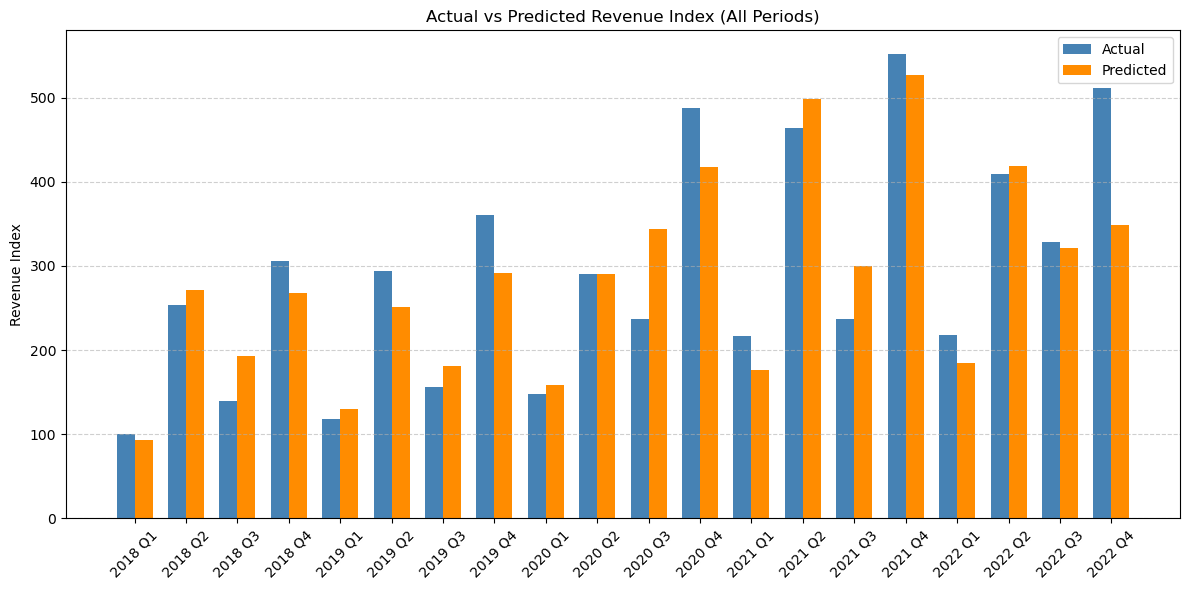

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Predicting for all periods
df_features['predicted_revenue_index'] = model.predict(df_features[feature_cols])

# Set up x-axis
x = np.arange(len(df_features))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_features['revenue_index'], width, label='Actual', color='steelblue')
plt.bar(x + width/2, df_features['predicted_revenue_index'], width, label='Predicted', color='darkorange')

plt.xticks(x, df_features['period'], rotation=45)
plt.ylabel('Revenue Index')
plt.title('Actual vs Predicted Revenue Index (All Periods)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



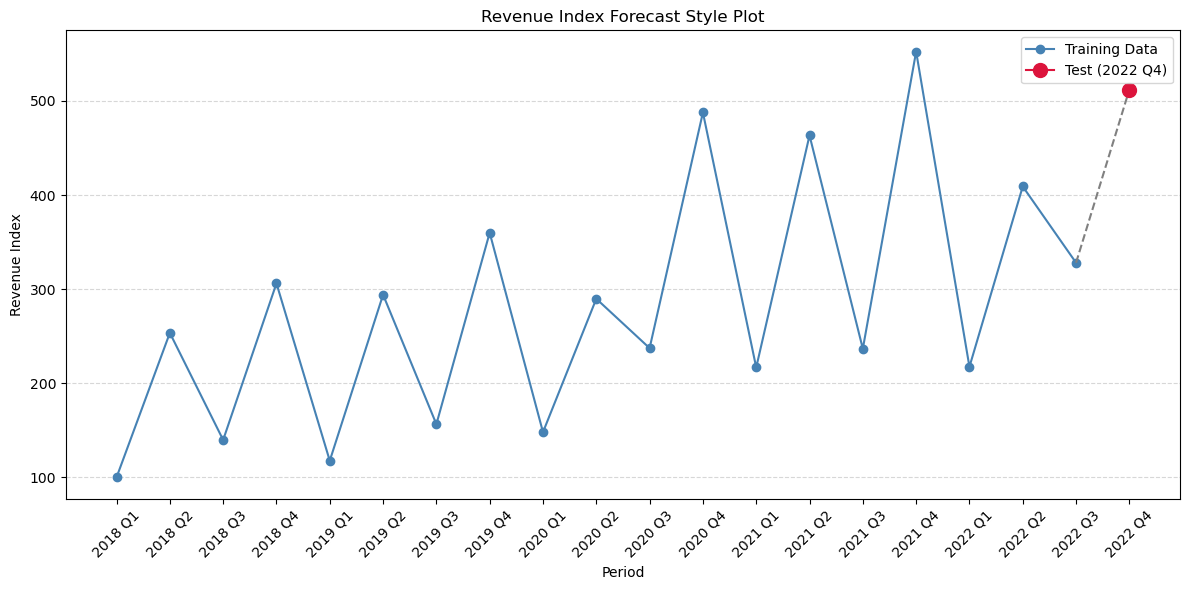

In [56]:


plt.figure(figsize=(12, 6))


plt.plot(train_df['period'], train_df['revenue_index'], marker='o', label='Training Data', color='steelblue')

# Connecting test point to the end
plt.plot([train_df.iloc[-1]['period'], test_df.iloc[0]['period']],
         [train_df.iloc[-1]['revenue_index'], test_df.iloc[0]['revenue_index']],
         linestyle='--', color='gray')

plt.plot(test_df['period'], test_df['revenue_index'], marker='o', markersize=10, label='Test (2022 Q4)', color='crimson')

plt.title("Revenue Index Forecast Style Plot")
plt.xlabel("Period")
plt.ylabel("Revenue Index")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

